In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE
import joblib
from xgboost import XGBClassifier

In [ ]:
df=pd.read_csv('meteorite-landings.csv')
print("Initial shape:", df.shape)
print(df.head())

Initial shape: (45716, 10)
       name   id nametype     recclass      mass  fall    year    reclat  \
0    Aachen    1    Valid           L5      21.0  Fell  1880.0  50.77500   
1    Aarhus    2    Valid           H6     720.0  Fell  1951.0  56.18333   
2      Abee    6    Valid          EH4  107000.0  Fell  1952.0  54.21667   
3  Acapulco   10    Valid  Acapulcoite    1914.0  Fell  1976.0  16.88333   
4   Achiras  370    Valid           L6     780.0  Fell  1902.0 -33.16667   

     reclong               GeoLocation  
0    6.08333     (50.775000, 6.083330)  
1   10.23333    (56.183330, 10.233330)  
2 -113.00000  (54.216670, -113.000000)  
3  -99.90000   (16.883330, -99.900000)  
4  -64.95000  (-33.166670, -64.950000)  


In [ ]:
df = df.dropna(subset=['mass', 'year', 'reclat', 'reclong', 'fall'])  # remove missing values
df['year'] = pd.to_datetime(df['year'], errors='coerce').dt.year
df = df.dropna(subset=['year'])


<ipython-input-8-3584752765>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = pd.to_datetime(df['year'], errors='coerce').dt.year


In [ ]:
df = df[df['mass'] > 0]
df = df[(df['reclat'].between(-90, 90)) & (df['reclong'].between(-180, 180))]
df = df[df['mass'] < 1e6]  # remove extreme outliers
print("Cleaned shape:", df.shape)

Cleaned shape: (38044, 10)


In [ ]:
df['log_mass'] = np.log1p(df['mass'])  # log transform of mass
df['decade'] = (df['year'] // 10) * 10     # decade feature
df['fall'] = df['fall'].apply(lambda x: 1 if x == 'Fell' else 0)  # target encoding

In [ ]:
kmeans = KMeans(n_clusters=10, random_state=42)
df['location_cluster'] = kmeans.fit_predict(df[['reclat', 'reclong']])

In [ ]:
features = ['log_mass', 'year', 'decade', 'location_cluster']
X = df[features]
y = df['fall']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [ ]:
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

In [ ]:
class_ratio=y.value_counts()[0] / y.value_counts()[1]

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb = XGBClassifier(
    scale_pos_weight=class_ratio,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='f1',  # or 'roc_auc'
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_bal, y_train_bal)
best_model = grid_search.best_estimator_

# Evaluate
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("Best Params:", grid_search.best_params_)
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

# Save the best model
joblib.dump(best_model, "meteorite_model_xgb_tuned.pkl")


Fitting 3 folds for each of 72 candidates, totalling 216 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:01:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Params: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
              precision    recall  f1-score   support

           0       1.00      0.70      0.82      7397
           1       0.08      0.97      0.15       212

    accuracy                           0.70      7609
   macro avg       0.54      0.83      0.49      7609
weighted avg       0.97      0.70      0.80      7609

ROC AUC Score: 0.9266642391994715


['meteorite_model_xgb_tuned.pkl']

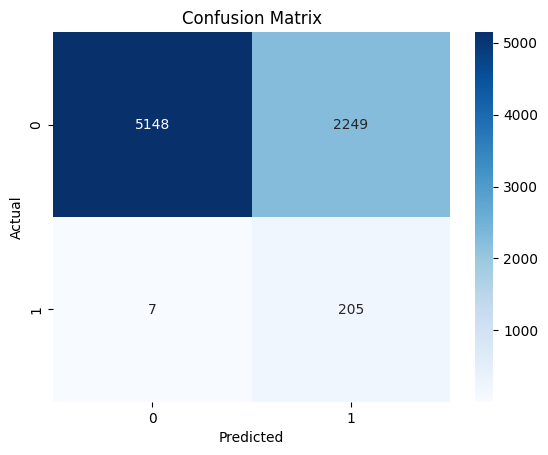

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

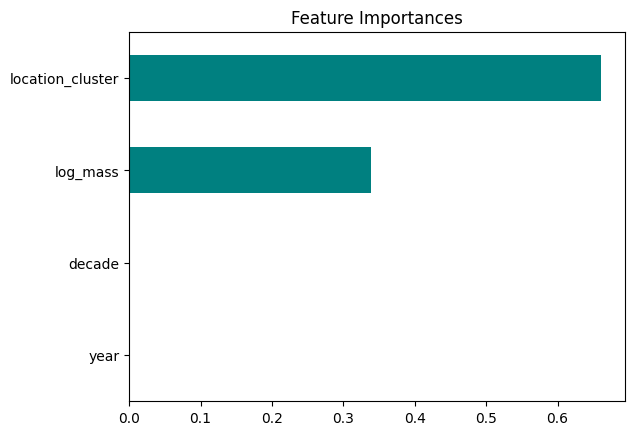

In [ ]:
importances = pd.Series(best_model.feature_importances_, index=features)
importances.sort_values().plot(kind='barh', title="Feature Importances", color='teal')
plt.show()